In [252]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Part 1 - Exploratory Data Analysis

We first create a dataframe in which we load and read our `json` dataset

In [131]:
df = pd.read_json(r"logins.json")
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


We check for NaN under the entire dataframe

In [132]:
df['login_time'].isnull().values.any()

False

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


We aggregate login counts based on 15 mins time intervals and count them

In [134]:
#resampling the dataframe to 15-min intervals
df_resample = df.resample("15min", on="login_time").count()
#rename & reset the new df index
#df_resample.index.name = "15_min_interval"
#df_resample.reset_index(inplace=True)
#rename the newly aggregated 'login_time' column 
df_resample.rename({"login_time":"login_counts"}, axis=1, inplace=True)
df_resample.head()

,login_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [135]:
df_resample.tail()

,login_counts
login_time,
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2
1970-04-13 18:30:00,7
1970-04-13 18:45:00,6


Text(0.5, 1.0, '15-min interval login counts')

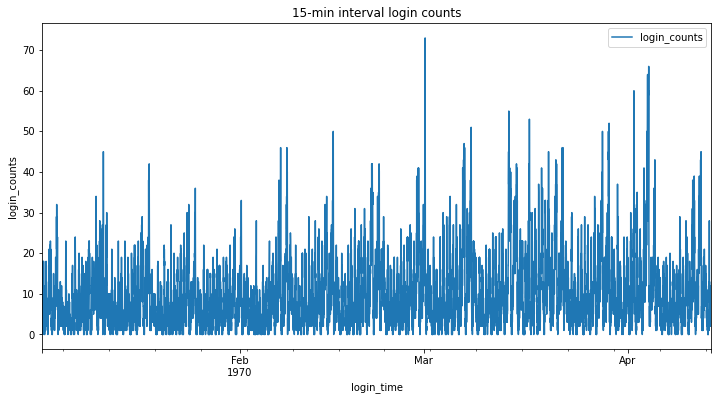

In [136]:
df_resample.plot(kind='line',figsize=(12,6))
plt.ylabel('login_counts')
plt.title('15-min interval login counts')

The 15-min login counts plot, shows that the counts seem to periodically increase and decrease with the average counts increasing over time between January and April.

We can find out the number of logins for each date

In [137]:
df_date = df_resample.resample('1D').sum()
df_date.head()

,login_counts
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


Text(0.5, 1.0, 'Daily 15-min interval login counts')

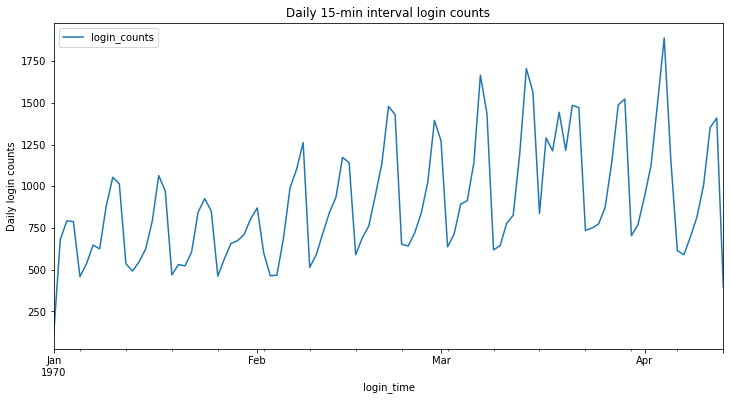

In [80]:
df_date.plot(kind='line',figsize=(12,6))
plt.ylabel('Daily login counts')
plt.title('Daily 15-min interval login counts')

On average, the spike in the number of daily login counts increased in the course of 4 months.

In [138]:
df_date[df_date['login_counts'] ==df_date['login_counts'].max()]

,login_counts
login_time,
1970-04-04,1889


In [139]:
df_date[df_date['login_counts'] ==df_date['login_counts'].min()]

,login_counts
login_time,
1970-01-01,112


The most 15-min interval login counts was observed on April 4 and the least 15-min interval login counts was observed on Jan 1.

We can find which hour of the day and which day of the week experiments a spike in logins

In [140]:
idx = df_resample.index 
df_resample['day'] = idx.day_name()

In [141]:
df_resample.head()

,login_counts,day
login_time,,
1970-01-01 20:00:00,2,Thursday
1970-01-01 20:15:00,6,Thursday
1970-01-01 20:30:00,9,Thursday
1970-01-01 20:45:00,7,Thursday
1970-01-01 21:00:00,1,Thursday


In [142]:
#counting total number of logins per day name
df_day = df_resample.groupby("day").sum()[["login_counts"]]
df_day.head(7)

,login_counts
day,
Friday,15208
Monday,8823
Saturday,19377
Sunday,18167
Thursday,11960
Tuesday,9268
Wednesday,10339


If we add all the `login_counts` and group them by the name of a day, we realize maybe not surprisingly that most logins were made accumulatively on *Saturday*, followed by  *Sunday* (so basically during the weekend) and the least we made on *Monday*.

In [143]:
#counting total number of logins per day name
df_day['daily_avg'] = df_resample.groupby("day").mean()[["login_counts"]]
df_day.head(7)

,login_counts,daily_avg
day,,
Friday,15208,10.561111
Monday,8823,6.213380
Saturday,19377,13.456250
Sunday,18167,12.615972
Thursday,11960,8.794118
Tuesday,9268,6.895833
Wednesday,10339,7.692708


Even if we pay attention to the average login counts per day name, we come to the same conclusion as above that on average, there were more logins on Saturday and least on Monday.

What if we wanted to know how the number of 15-min interval logins changes hourly in a day?

In [144]:
df_resample['hour'] = df_resample.index.hour
df_hour = df_resample.groupby("hour").sum()[["login_counts"]]
#counting total number of logins per hour
df_hour['hourly_avg'] = df_resample.groupby("hour").mean()[["login_counts"]]
df_hour.head()

,login_counts,hourly_avg
hour,,
0,5993,14.688725
1,6317,15.482843
2,5800,14.215686
3,4831,11.840686
4,5034,12.338235


In [145]:
df_hour[df_hour['hourly_avg'] == df_hour['hourly_avg'].max()]

,login_counts,hourly_avg
hour,,
22,6607,16.193627


In [146]:
df_hour[df_hour['hourly_avg'] == df_hour['hourly_avg'].min()]

,login_counts,hourly_avg
hour,,
7,815,1.997549


We observe that most logins (**16.2 on average**) were made at **10 PM** and the least number of logins (**2 on average**) was realized at **7 AM**

We can combine the two temporal variables (hour and day) to check how on average the total login counts in a 15 minute time interval fluctuates daily.

[Text(0.5, 1.0, 'Average daily login counts  per hour')]

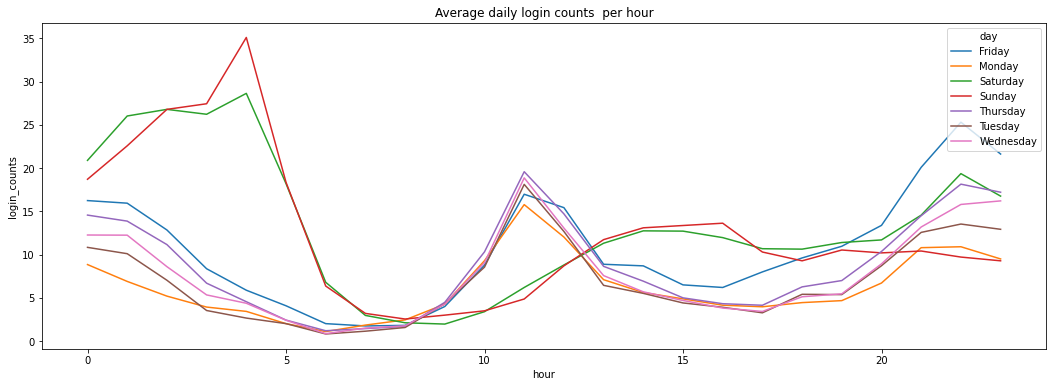

In [147]:
df_combined = df_resample.groupby(['hour', 'day']).mean().reset_index()
f, axes = plt.subplots(figsize=(18,6))
ax = sns.lineplot(x='hour', y='login_counts', data=df_combined, hue='day')
ax.legend(loc='upper right')
ax.set(title='Average daily login counts  per hour')

We see that on average, most daily login counts were made at around 4 AM on Sunday and the least daily login counts were made at around 6 AM on Monday. 

## Part 2 ‐ Experiment and metrics design

In this experiment, we want to check if reimbursing all toll costs will increase the  availability of driver partners in both cities. Using any tracking device, like a smartphone, we can track driver partners' locations during the time they are working and calculate the percentage of time they spend in each city. In order to not spoil our data, we can analyze this percentage of time spent in city that is not the driver's, during the weekday and during the weekend separately. This is because drivers might increase the traffic in city that is not theirs during the weekends, just because they have more active working time than during the weekdays, and not because of the incentives of toll costs reimbursements.

For statistical testing, we can use a **z-test** for the difference of means of percentage time that driver partners spent in either city. The z-test would be appropriate since the sample size of drivers will be greater than 30, each data point would be independent of others. even though our data should be normally distributed, for a large sample it will not matter much because with the Central Limit Theorem, the sampling distribution of the means  will approach the normal distribution. Finally, our data will be randomly selected from the population.

In this experiment,

* First, randomly choose 100 drivers in each city (assuming that both cities have relatively the same size, and that there are more than 1000 drivers in each city). Each driver should have a tracking device that is always on during their working hours.
* Collect data from their tracking devices during a sampling period of 2 weeks 
* Calculate the percentage of time each driver from the sample spends in each city on weekdays and on weekends.
* Put in place the toll costs reimbursement program, let these randomly selected drivers know about the program, and that it will start at the end of the 2 weeks for a period of two weeks again. 
* Use the same drivers during this 2 week-period of toll costs reimbursement program, and calculate the percentage of time they spend in each city again.
* Test the samples using the **z-test** for proportions of means, with **null hypothesis ($H_0$)** being that there is no difference in the proportions of means for the percentage of times spent in each city, and the **alternative hypothesis($H_a$)** being that the difference in the proportions of means for the percentage of times spent in each city is **statistically significant**.

If the increase in the percentage of time that drivers spent in city that is not theirs, is statistically significant, we can conclude that the implementation of the toll cost reimbursement was successful. But for business point of view, further analysis should be conducted to check how implementing this policy affects the company's profits. This can be done by comparing the total profits of the company prior to the implementation of the reimbursement program, the total profit after the program was implemented, and the total costs of the reimbursement program.  


## Part 3 ‐ Predictive modeling

In [261]:
df_new = pd.read_json(r"ultimate_data_challenge.json")
df_new.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [262]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [263]:
df_new.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

We see that there are some cleaning to do, but before we do that, let's figure out the percentage of users who qualified as `active`, those are users who took a trip in the preceding 30 days.

In [264]:
#Qualify a user as active in the first 30 days
df_new['active_in_first_30days'] = df_new['trips_in_first_30_days'].apply(lambda row: 1 if row != 0 else 0)
df_new.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_in_first_30days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


In [265]:
# percentage of active users in the first 30 days
(df_new.groupby(['active_in_first_30days']).size() / df_new['active_in_first_30days'].count()) * 100

active_in_first_30days
0    30.78
1    69.22
dtype: float64

Within 30 days of signing up to Ultimate, active users were about 69%. We are tasked to find how many users are retained as active in the preceding 30 days though. In our data we already have a column named `last_trip_date`. In order to calculate the 'preceding 30 days', we will figure out the latest date (maximum of the `last_trip_date`) then calculate if there is at least one trip (for active users) in the 30 days preceding that date, if none the user will be deemed inactive.

In [266]:
# convert to timestamp
df_new['last_trip_date'] = pd.to_datetime(df_new['last_trip_date'])
last_date = df_new['last_trip_date'].max()
print(last_date)

2014-07-01 00:00:00


Users were active if their `last_trip_date` was within the 30 days preceding `2014-07-01` otherwise they were inactive

In [267]:
#Qualify a user as active in the preceding 30 days
df_new['active_in_last_30days'] = df_new['last_trip_date'].apply(lambda row: 1 if (last_date-row).days<=30 else 0)
df_new.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_in_first_30days,active_in_last_30days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1,0


In [268]:
# percentage of active users in the last 30 days
(df_new.groupby(['active_in_last_30days']).size() / df_new['active_in_last_30days'].count()) * 100

active_in_last_30days
0    62.392
1    37.608
dtype: float64

In the preceding 30 days of the last date of data collection, only **37.6%** of users were qualified as active, down from 69.22% in the first 30 days.

### Some Cleaning

The column `avg_rating_of_driver` has 8122 NaNs, we can replace them with the mean 

In [269]:
mean_rating_of_driver = df_new['avg_rating_of_driver'].mean()
df_new['avg_rating_of_driver'] = df_new['avg_rating_of_driver'].fillna(value=mean_rating_of_driver)

The column `avg_rating_by_driver` has 201 NaNs, we can replace them with the median which makes sense for ratings than a mean

In [270]:
mean_rating_by_driver = df_new['avg_rating_by_driver'].median()
df_new['avg_rating_by_driver'] = df_new['avg_rating_by_driver'].fillna(value=mean_rating_by_driver)

The column `phone` has 396 NaNs, we will drop them.

In [271]:
df_new = df_new.drop(df_new[df_new['phone'].isna() == True].index, axis=0)

In [272]:
print(df_new.isna().any())

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver      False
avg_surge                 False
last_trip_date            False
phone                     False
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver      False
active_in_first_30days    False
active_in_last_30days     False
dtype: bool


Before continuing, let's map the bool values of `ultimate_black_user` to 0 and 1 for convenience

In [273]:
df_new['ultimate_black_user'] = df_new['ultimate_black_user'].map({True:1, False:0})

In [274]:
df_new.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_in_first_30days,active_in_last_30days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,1,0


### Some EDA

In [275]:
#convert to timestamp
df_new['signup_date'] = pd.to_datetime(df_new['signup_date'])
# create a column for users active in their 6th month
active_in_their_6th_month = lambda date: 0 if date['last_trip_date'] - date['signup_date'] <= timedelta(days=30*5) else 1 

In [276]:
df_new['active_in_their_6th_month'] = df_new.apply(active_in_their_6th_month, axis=1)

In [277]:
df_new.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_in_first_30days,active_in_last_30days,active_in_their_6th_month
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,1,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,1,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,1,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,1,0,0


In [278]:
pd.pivot_table(df_new, index='active_in_their_6th_month',  aggfunc={'avg_rating_by_driver':'median'})

,avg_rating_by_driver
active_in_their_6th_month,
0,5.0
1,4.8


Users who were still active in their 6th month, have surprisingly a lower median rating which might be due to the fact that they requested more rides than those who were inactive. This feature will be importating in our predictive model.

In [279]:
pd.pivot_table(df_new, index='active_in_their_6th_month',  aggfunc={'avg_dist':'mean'})

,avg_dist
active_in_their_6th_month,
0,6.080718
1,4.871536


Interestingly on average, in their first 30 days after signup, the average distance per trip made by active users was shorter than that of users who ended up being inactive! This feature definitely will play a significant role in our model.

### Predictive Model

We wish to build a predictive model to help Ultimate determine if a user will still be active after 6 months in the system.

In [280]:
df_new['active_in_their_6th_month'].value_counts(normalize=True)

0    0.755786
1    0.244214
Name: active_in_their_6th_month, dtype: float64

Without building any model, we can rudimentarily predict that 24.4% of users will be active in their sixth month. We need to do better!

First let's drop the three features we don't need. We dropped `active_in_last_30days` since it is almost synonymous to the feature `active_in_their_6th_month` and can probably contribute to the model overfitting.

In [281]:
df_new = df_new.drop(columns=['signup_date', 'last_trip_date', 'active_in_last_30days'], axis=1)

Our data contains both numeric and categorical features. We first create dummy variables for categorical data. 

In [282]:
# Create Dummy variables 
categorical_features = ['city', 'phone', 'ultimate_black_user']
df_features = pd.get_dummies(df_new, columns=categorical_features)

In [283]:
y = df_features['active_in_their_6th_month']
df_features = df_features.drop(['active_in_their_6th_month'], axis=1)

 Since most of our numeric data have different orders of magnitude, we first scale them

In [284]:
#scaling numeric data
scaler = QuantileTransformer()
X = scaler.fit_transform(df_features)

We now split our data and choose 30% of them to be used for testing. We will use all features that remain in our dataset except `active_in_their_6th_month` for predictor X, and our target y will be the `active_in_their_6th_month`.

In [285]:
#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

Our problem is a classification problem where we want to predict if in their sixth month, users are still active or not. Therefore, we choose we use a *random forest classifier*, which is near the top of the classification algorithms.

In [286]:
#build random forest model with 500 estimators
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [287]:
rf.score(X_test,y_test)

0.7706625453568069

In [288]:
test_accuracy = metrics.accuracy_score(y_test, y_pred)
test_f1_score = metrics.f1_score(y_test, y_pred)
print(f"Model accuracy: {test_accuracy*100:.2f}%")
print(f"Model F1 Score: {test_f1_score:.2f}")

Model accuracy: 77.07%
Model F1 Score: 0.49


Our model can predict with **77%** accuracy if a user will still be active in their sixth month or not. The $F_1$ value of **0.49** which weighs the relevance of our model based on the *precision* and *recall* values, is also decent.

In [289]:
#precision & recall
precision_recall_fscore_support(y_test,y_pred)

(array([0.83365783, 0.52818508]),
 array([0.87181303, 0.45203569]),
 array([0.85230862, 0.48715252]),
 array([11296,  3586]))

In [290]:
feature_importance = zip(list(df_features.columns),rf.feature_importances_)
feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse=True)
df_importance = pd.DataFrame(feature_importance, columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
0,avg_dist,0.298207
1,weekday_pct,0.149129
2,avg_rating_by_driver,0.104936
3,avg_rating_of_driver,0.096178
4,surge_pct,0.095812
5,avg_surge,0.077949
6,trips_in_first_30_days,0.074859
7,city_King's Landing,0.022412
8,phone_Android,0.013532
9,city_Astapor,0.012773


The result suggests perhaps the first 7 features out of 16 as the most important for prediction. Features like `avg_dist`,  `weekday_pct` and `avg_rating_by_driver` are very important. Features like `phone` and `ultimate_black_user` seem unimportant for our model compared to the first 7 features.

Based on the insights gained from the model, we can give a few recommendations to Ultimate in order to improve its long term rider rentention:

* Offer incentives to users who exceed the average distance per trip in their 30 days after signing up
* Offer incentives to users to exceed the average of percentage of weekday trips
* Offer incentives to drivers who receive higher ratings by users
* Offer incentives to users who receive higher ratings by drivers
* Offer incentives to users who get more trips in their first 30 days